In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import roc_curve,auc

2024-08-25 11:04:50.818547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 11:04:50.818639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 11:04:50.972141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#load the CSV files
train_df = pd.read_csv("/kaggle/input/icts-third-dataset/ICTS_DATASET_CROPPED/train_final.csv")
test_df = pd.read_csv("/kaggle/input/icts-third-dataset/ICTS_DATASET_CROPPED/test_final.csv")

#convert class labels to strings
train_df['class'] = train_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)


In [3]:
#balance the dataset by oversampling the minority classes
class_counts = train_df['class'].value_counts()
max_class_count = class_counts.max()

balanced_train_df = train_df.copy()
class_counts = train_df['class'].value_counts()
for class_label in class_counts[class_counts < max_class_count].index:
    class_df = train_df[train_df['class'] == class_label]
    oversampled_class_df = class_df.sample(max_class_count, replace = True)
    balanced_train_df = pd.concat([balanced_train_df, oversampled_class_df], axis = 0)
    


In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(balanced_train_df, test_size = 0.2, stratify = balanced_train_df['class'])

In [7]:
#directories for the train adn test images

train_image_dir = '/kaggle/input/icts-third-dataset/ICTS_DATASET_CROPPED/images/train'
test_image_dir = '/kaggle/input/icts-third-dataset/ICTS_DATASET_CROPPED/images/test'

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_image_dir,  # Use the same directory as training data
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_image_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the number of classes
num_classes = len(train_generator.class_indices)

Found 25294 validated image filenames belonging to 17 classes.
Found 6324 validated image filenames belonging to 17 classes.
Found 1968 validated image filenames belonging to 17 classes.


In [11]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y=train_df['class'])
class_weights_dict = dict(enumerate(class_weights))

In [12]:
# Create the model
input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)

# ResNet101 model
resnet101_base = ResNet101(include_top=False, weights='imagenet', input_tensor=input_layer)
resnet101_output = Flatten()(resnet101_base.output)

# InceptionV3 model
inceptionv3_base = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_layer)
inceptionv3_output = Flatten()(inceptionv3_base.output)

# Concatenate the outputs
combined_output = concatenate([resnet101_output, inceptionv3_output])

# Add a fully connected layer
fc_layer = Dense(256, activation='relu')(combined_output)

# Add a final softmax layer
output_layer = Dense(num_classes, activation='softmax')(fc_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    class_weight=class_weights_dict
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724584445.531216     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724584445.812614     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


791/791 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.7224 - loss: 0.8968

W0000 00:00:1724585136.994332     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


791/791 ━━━━━━━━━━━━━━━━━━━━ 996s 959ms/step - accuracy: 0.7226 - loss: 0.8962 - val_accuracy: 0.7098 - val_loss: 1.6834 - learning_rate: 1.0000e-05
Epoch 2/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 604s 760ms/step - accuracy: 0.9671 - loss: 0.0827 - val_accuracy: 0.9864 - val_loss: 0.0371 - learning_rate: 1.0000e-05
Epoch 3/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 604s 760ms/step - accuracy: 0.9802 - loss: 0.0472 - val_accuracy: 0.9956 - val_loss: 0.0163 - learning_rate: 1.0000e-05
Epoch 4/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 596s 750ms/step - accuracy: 0.9888 - loss: 0.0281 - val_accuracy: 0.9927 - val_loss: 0.0215 - learning_rate: 1.0000e-05
Epoch 5/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 604s 759ms/step - accuracy: 0.9902 - loss: 0.0242 - val_accuracy: 0.9994 - val_loss: 0.0031 - learning_rate: 1.0000e-05
Epoch 6/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 596s 750ms/step - accuracy: 0.9944 - loss: 0.0169 - val_accuracy: 0.9983 - val_loss: 0.0036 - learning_rate: 1.0000e-05
Epoch 7/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 595s 749ms/

In [14]:
# Load the best model
best_model = load_model('best_model.keras')

# Predict the test set
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

 2/62 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step

W0000 00:00:1724590631.088812     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


62/62 ━━━━━━━━━━━━━━━━━━━━ 48s 581ms/step
Confusion Matrix:
 [[404   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 134   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   9   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  83   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  55   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  55   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 102   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  55   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 158   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  87   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  69   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 173   0   0   2   0]
 [  0   0   0   

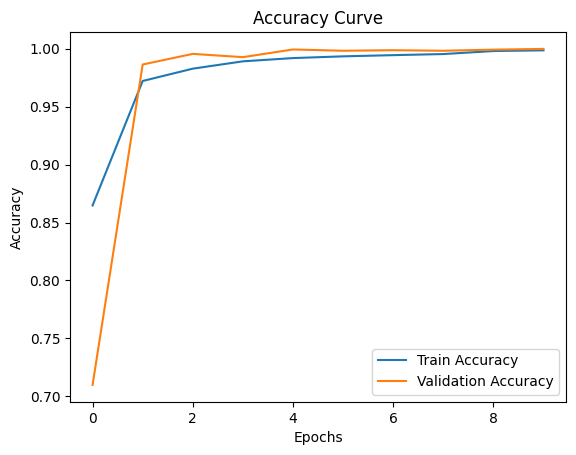

In [15]:
# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

# Plot accuracy curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


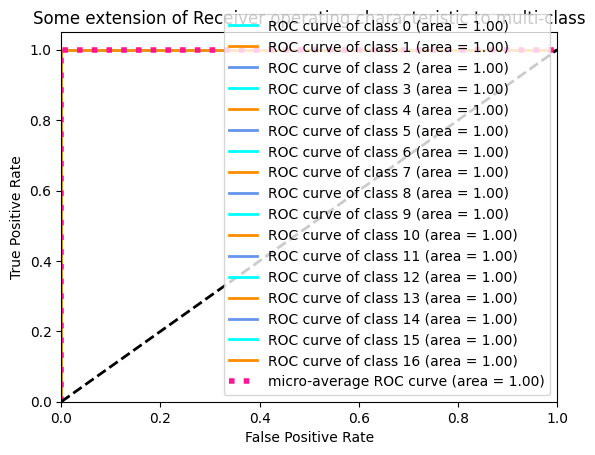

In [16]:
# Plot ROC curve for each class
# Binarize the output
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_pred_bin = label_binarize(y_pred_classes, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()




In [17]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Extract TP, TN, FP, FN from confusion matrix
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Calculate sensitivity and specificity for each class
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Print results for each class
for i, cls in enumerate(test_generator.class_indices.keys()):
    print(f"Class {cls}:")
    print(f"  Sensitivity: {sensitivity[i]:.4f}")
    print(f"  Specificity: {specificity[i]:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print()

# Calculate macro-average sensitivity and specificity
macro_sensitivity = np.mean(sensitivity)
macro_specificity = np.mean(specificity)
print("Macro-average Sensitivity:", macro_sensitivity)
print("Macro-average Specificity:", macro_specificity)

Class 1:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 10:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 11:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 12:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 13:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 14:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 15:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 16:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 17:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 2:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 3:
  Sensitivity: 1.0000
  Specificity: 1.0000
  Accuracy: 0.9975

Class 4:
  Sensitivity: 1.0000
  Specificity: 0.9984
  Accuracy: 0.9975

Class 5:
  Sensitivity: 0.9886
  Specificity: 1.0000
  Accuracy: 0.9975

Class 6:
  Sensitivity: 1.0000
  Specificit

In [18]:
# Train individual ResNet101 model
resnet101_model = Model(inputs=resnet101_base.input, outputs=Dense(num_classes, activation='softmax')(resnet101_output))
# Compile the ResNet101 model
resnet101_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the individual models
history_resnet101 = resnet101_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    class_weight=class_weights_dict
)

In [ ]:
# Predict the test set with ResNet101 model
y_pred_resnet101 = resnet101_model.predict(test_generator)
y_pred_resnet101_classes = np.argmax(y_pred_resnet101, axis=1)
y_true = test_generator.classes

# Calculate metrics for ResNet101
print("ResNet101 Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_resnet101_classes):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_resnet101_classes, average=None)}")
print(f"Recall: {recall_score(y_true, y_pred_resnet101_classes, average=None)}")
print(f"F1 Score: {f1_score(y_true, y_pred_resnet101_classes, average=None)}")

# Calculate sensitivity and specificity for ResNet101
conf_matrix_resnet101 = confusion_matrix(y_true, y_pred_resnet101_classes)
TP_resnet101 = np.diag(conf_matrix_resnet101)
FP_resnet101 = np.sum(conf_matrix_resnet101, axis=0) - TP_resnet101
FN_resnet101 = np.sum(conf_matrix_resnet101, axis=1) - TP_resnet101
TN_resnet101 = np.sum(conf_matrix_resnet101) - (TP_resnet101 + FP_resnet101 + FN_resnet101)

sensitivity_resnet101 = TP_resnet101 / (TP_resnet101 + FN_resnet101)
specificity_resnet101 = TN_resnet101 / (TN_resnet101 + FP_resnet101)

print(f"Sensitivity: {sensitivity_resnet101}")
print(f"Specificity: {specificity_resnet101}")

print("\nAverage Metrics:")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1_score:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")

In [ ]:
# Train individual InceptionV3 model
inceptionv3_model = Model(inputs=inceptionv3_base.input, outputs=Dense(num_classes, activation='softmax')(inceptionv3_output))
# Compile the InceptionV3 model

inceptionv3_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history_inceptionv3 = inceptionv3_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    class_weight=class_weights_dict
)

In [ ]:
# Predict the test set with InceptionV3 model
y_pred_inceptionv3 = inceptionv3_model.predict(test_generator)
y_pred_inceptionv3_classes = np.argmax(y_pred_inceptionv3, axis=1)

# Calculate metrics for InceptionV3
print("InceptionV3 Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_inceptionv3_classes):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_inceptionv3_classes, average=None)}")
print(f"Recall: {recall_score(y_true, y_pred_inceptionv3_classes, average=None)}")
print(f"F1 Score: {f1_score(y_true, y_pred_inceptionv3_classes, average=None)}")

# Calculate sensitivity and specificity for InceptionV3
conf_matrix_inceptionv3 = confusion_matrix(y_true, y_pred_inceptionv3_classes)
TP_inceptionv3 = np.diag(conf_matrix_inceptionv3)
FP_inceptionv3 = np.sum(conf_matrix_inceptionv3, axis=0) - TP_inceptionv3
FN_inceptionv3 = np.sum(conf_matrix_inceptionv3, axis=1) - TP_inceptionv3
TN_inceptionv3 = np.sum(conf_matrix_inceptionv3) - (TP_inceptionv3 + FP_inceptionv3 + FN_inceptionv3)

sensitivity_inceptionv3 = TP_inceptionv3 / (TP_inceptionv3 + FN_inceptionv3)
specificity_inceptionv3 = TN_inceptionv3 / (TN_inceptionv3 + FP_inceptionv3)

print(f"Sensitivity: {sensitivity_inceptionv3}")
print(f"Specificity: {specificity_inceptionv3}")

print("\nAverage Metrics:")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1_score:.4f}")
print(f"Average Sensitivity: {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
